# 10. Data structured (votes)
## Contents
- Prerequisites
- Data retrieval
    - API test
    - API processing
    - API url
    - API extraction
- Data processing  
------------------------------------------------
## Prerequisites

In [43]:
import requests
import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
file_path = 'C:/Users/Koen.Janssen/OneDrive/Documents/TILBURG UNIVERSITY/Thesis/Data/'
api_path  = 'https://gegevensmagazijn.tweedekamer.nl/OData/v4/2.0/'  

------------------------------------------------
<br>
<br>
<br>

## Data retrieval
### API test

In [44]:
dur = time.time()
# -------------------------------------------------------------------------------------~----------------------------------------

api_url = api_path                                                                     # define API url
response = requests.get(api_url)                                                       # request response

if response.status_code == 200:                                                        # if reponse is 200
    print("API request successfull")                                                   # print succes
else:                                                                                  # if not
    print(f"API request failed, code: {response.status_code}")                         # print failure + code

# -------------------------------------------------------------------------------------~----------------------------------------
print()
print('-----------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")

API request successfull

-----------------------------------------------------------------------------------------------------------------------
Code duration: 0.113 seconds


### API processing

In [8]:
# select columns
# -------------------------------------------------------------------------------------~----------------------------------------
stemming_columns = "Id, Soort"
fractie_columns = "Id, Afkorting"
besluit_columns = "Id"
zaak_columns = "Id, GestartOp"
document_columns = "Id,Titel,Onderwerp"

# filter columns
# -------------------------------------------------------------------------------------~----------------------------------------
stemming_filters = "Verwijderd eq false and Soort ne 'Niet deelgenomen' and Vergissing eq false" 
fractie_filters = "Verwijderd eq false" 
besluit_filters = "Verwijderd eq false" 
zaak_filters = "Verwijderd eq false and Soort eq 'Motie' and Afgedaan ne false and Year(GestartOp) ge 2017" 
document_filters = "Verwijderd eq false and ContentType eq 'application/pdf' and Soort eq 'Motie' or Soort eq 'Motie (gewijzigd/nader)'"

### API url

In [9]:
# base URL + main table Stemming
# -------------------------------------------------------------------------------------~----------------------------------------
api_url = api_path + "Stemming"                                                        # api_path + main table Stemming
api_url += "?$select=" + stemming_columns                                              ## select Stemming columns
api_url += "&$filter=" + stemming_filters                                              ## filter Stemming

# 1st level expand into Fractie and Besluit
# -------------------------------------------------------------------------------------~----------------------------------------
api_url += "&$expand="                                                                 # expand 1st level
api_url += "Fractie"                                                                     # join Fractie             
api_url += "($select=" + fractie_columns                                                 ## select Fractie columns
api_url += ";$filter=" + fractie_filters                                                 ## filter Fractie
api_url += "),Besluit"                                                                   # join Besluit
api_url += "($select=" + besluit_columns                                                 ## select Besluit columns
api_url += ";$filter=" + besluit_filters                                                 ## filter Besluit

# 2nd level expand into Zaak
# -------------------------------------------------------------------------------------~----------------------------------------
api_url += ";$expand="                                                                      # expand 2nd level
api_url += "Zaak"                                                                           # join Zaak
api_url += "($select=" + zaak_columns                                                       ## select Zaak columns
api_url += ";$filter=" + zaak_filters                                                       ## filter Zaak

# 3rd level expand into Document
# -------------------------------------------------------------------------------------~----------------------------------------
api_url += ";$expand="                                                                         # expand 3rd level
api_url += "Document"                                                                          # join Document
api_url += "($select=" + document_columns                                                      ## select Document columns
api_url += ";$filter=" + document_filters + ")))"                                              ## filter Document

### API extraction

In [13]:
dur = time.time()
# -------------------------------------------------------------------------------------~----------------------------------------

# 1st level extraction
# -------------------------------------------------------------------------------------~----------------------------------------
page = 1                                                                               # Define page one
while True:                                                                            # Start page loop
    page_dur = time.time()                                                             # Define page duration 
    r = requests.get(api_url, params={'$top': 250, '$skip': (page - 1) * 250})         # Request api data
    json_data = r.json()['value']                                                      # Transform json data
    json_normalized = pd.json_normalize(json_data)                                     # Normalize json data
    if json_normalized.empty: break                                                    # Break when empty
    tables = json_normalized                                                           # 1st level
    
# 2nd level extraction
# -------------------------------------------------------------------------------------~----------------------------------------
    tables_exploded = tables.explode("Besluit.Zaak")                                   # Explode nested json
    stemming = tables_exploded.drop("Besluit.Zaak", axis=1)                            # Drop nested json column
    zaak = pd.json_normalize(tables_exploded["Besluit.Zaak"])                          # Normalize nested json
    
    stemming = stemming.add_prefix('stemming_')                                        # Add prefix, prevent duplicates
    zaak = zaak.add_prefix('zaak_')                                                    # Add prefix, prevent duplicates
    stemming['stemming_index'] = range(len(stemming))                                  # Define new index
    zaak['zaak_index'] = range(len(zaak))                                              # Define new index
    stemming.reset_index(drop=True, inplace=True)                                      # Drop old index
    zaak.reset_index(drop=True, inplace=True)                                          # Drop old index
    stemming.sort_values(by= ('stemming_index') , inplace=True)                        # Sort by new index
    zaak.sort_values(by= ('zaak_index') , inplace=True)                                # Sort by new index

    tables = pd.concat([stemming, zaak], axis=1)                                       # Concat using sorted index
    tables.sort_values(by= ('stemming_index'), inplace=True)                           # Sort result
    tables.drop([ ('stemming_index'), ('zaak_index')], axis=1, inplace=True)           # Drop new indexes

# 3rd level extraction
# -------------------------------------------------------------------------------------~----------------------------------------
    tables_exploded = tables.explode("zaak_Document")                                  # Explode nested json
    stemmingzaak = tables_exploded.drop("zaak_Document", axis=1)                       # Drop nested json column
    document = pd.json_normalize(tables_exploded["zaak_Document"])                     # Normalize nested json

    stemmingzaak = stemmingzaak.add_prefix('stemmingzaak_')                            # Add prefix, prevent duplicates
    document = document.add_prefix('document_')                                        # Add prefix, prevent duplicates
    stemmingzaak['stemmingzaak_index'] = range(len(stemmingzaak))                      # Define new index
    document['document_index'] = range(len(document))                                  # Define new index
    stemmingzaak.reset_index(drop=True, inplace=True)                                  # Drop old index
    document.reset_index(drop=True, inplace=True)                                      # Drop old index
    stemmingzaak.sort_values(by= ('stemmingzaak_index') , inplace=True)                # Sort by new index
    document.sort_values(by= ('document_index') , inplace=True)                        # Sort by new index

    tables = pd.concat([stemmingzaak, document], axis=1)                               # Concat, using sorted index
    tables.sort_values(by= ('stemmingzaak_index'), inplace=True)                       # Sort result
    tables.drop([ ('stemmingzaak_index'), ('document_index')], axis=1, inplace=True)   # Drop new indexes
    tables.dropna(subset=['document_Id'], inplace=True)                                # Drop empty rows, due to filters

# data load
# -------------------------------------------------------------------------------------~----------------------------------------
    if page == 1: result = tables                                                      # Define result, first page
    else: result = pd.concat([result,tables], ignore_index=True)                       # Concat pages
    page_dur = round((time.time() - page_dur),2)                                       # Define page duration 
    print(f"Successful extraction (Page {page}) (Time {page_dur})")                    # Print page log
    page += 1                                                                          # Define next page

# -------------------------------------------------------------------------------------~----------------------------------------
file_url  = file_path + '11_data_structured_retrieved.csv'            
result.to_csv(file_url, index=False)    
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")                            

Successful extraction (Page 1) (Time 0.17)
Successful extraction (Page 2) (Time 0.17)
Successful extraction (Page 3) (Time 0.16)
Successful extraction (Page 4) (Time 0.18)
Successful extraction (Page 5) (Time 0.22)
Successful extraction (Page 6) (Time 0.22)
Successful extraction (Page 7) (Time 0.22)
Successful extraction (Page 8) (Time 0.18)
Successful extraction (Page 9) (Time 0.21)
Successful extraction (Page 10) (Time 0.18)
Successful extraction (Page 11) (Time 0.17)
Successful extraction (Page 12) (Time 0.16)
Successful extraction (Page 13) (Time 0.18)
Successful extraction (Page 14) (Time 0.21)
Successful extraction (Page 15) (Time 0.17)
Successful extraction (Page 16) (Time 0.17)
Successful extraction (Page 17) (Time 0.17)
Successful extraction (Page 18) (Time 0.16)
Successful extraction (Page 19) (Time 0.18)
Successful extraction (Page 20) (Time 0.22)
Successful extraction (Page 21) (Time 0.18)
Successful extraction (Page 22) (Time 0.18)
Successful extraction (Page 23) (Time 0.1

Successful extraction (Page 186) (Time 0.27)
Successful extraction (Page 187) (Time 0.33)
Successful extraction (Page 188) (Time 0.23)
Successful extraction (Page 189) (Time 0.19)
Successful extraction (Page 190) (Time 0.21)
Successful extraction (Page 191) (Time 0.21)
Successful extraction (Page 192) (Time 0.25)
Successful extraction (Page 193) (Time 0.2)
Successful extraction (Page 194) (Time 0.29)
Successful extraction (Page 195) (Time 0.4)
Successful extraction (Page 196) (Time 0.26)
Successful extraction (Page 197) (Time 0.19)
Successful extraction (Page 198) (Time 0.2)
Successful extraction (Page 199) (Time 0.23)
Successful extraction (Page 200) (Time 0.37)
Successful extraction (Page 201) (Time 0.39)
Successful extraction (Page 202) (Time 0.21)
Successful extraction (Page 203) (Time 0.21)
Successful extraction (Page 204) (Time 0.2)
Successful extraction (Page 205) (Time 0.2)
Successful extraction (Page 206) (Time 0.22)
Successful extraction (Page 207) (Time 0.19)
Successful extr

Successful extraction (Page 369) (Time 0.28)
Successful extraction (Page 370) (Time 0.22)
Successful extraction (Page 371) (Time 0.2)
Successful extraction (Page 372) (Time 0.19)
Successful extraction (Page 373) (Time 0.27)
Successful extraction (Page 374) (Time 0.27)
Successful extraction (Page 375) (Time 0.21)
Successful extraction (Page 376) (Time 0.22)
Successful extraction (Page 377) (Time 0.21)
Successful extraction (Page 378) (Time 0.21)
Successful extraction (Page 379) (Time 0.29)
Successful extraction (Page 380) (Time 0.24)
Successful extraction (Page 381) (Time 0.22)
Successful extraction (Page 382) (Time 0.28)
Successful extraction (Page 383) (Time 0.24)
Successful extraction (Page 384) (Time 0.25)
Successful extraction (Page 385) (Time 0.21)
Successful extraction (Page 386) (Time 0.22)
Successful extraction (Page 387) (Time 0.31)
Successful extraction (Page 388) (Time 0.2)
Successful extraction (Page 389) (Time 0.25)
Successful extraction (Page 390) (Time 0.21)
Successful e

Successful extraction (Page 552) (Time 0.23)
Successful extraction (Page 553) (Time 0.27)
Successful extraction (Page 554) (Time 0.24)
Successful extraction (Page 555) (Time 0.25)
Successful extraction (Page 556) (Time 0.26)
Successful extraction (Page 557) (Time 0.2)
Successful extraction (Page 558) (Time 0.27)
Successful extraction (Page 559) (Time 0.25)
Successful extraction (Page 560) (Time 0.29)
Successful extraction (Page 561) (Time 0.26)
Successful extraction (Page 562) (Time 0.24)
Successful extraction (Page 563) (Time 0.24)
Successful extraction (Page 564) (Time 0.29)
Successful extraction (Page 565) (Time 0.23)
Successful extraction (Page 566) (Time 0.24)
Successful extraction (Page 567) (Time 0.25)
Successful extraction (Page 568) (Time 0.33)
Successful extraction (Page 569) (Time 0.27)
Successful extraction (Page 570) (Time 0.25)
Successful extraction (Page 571) (Time 0.23)
Successful extraction (Page 572) (Time 0.27)
Successful extraction (Page 573) (Time 0.3)
Successful e

Successful extraction (Page 735) (Time 0.29)
Successful extraction (Page 736) (Time 0.79)
Successful extraction (Page 737) (Time 0.3)
Successful extraction (Page 738) (Time 0.27)
Successful extraction (Page 739) (Time 0.26)
Successful extraction (Page 740) (Time 0.25)
Successful extraction (Page 741) (Time 0.31)
Successful extraction (Page 742) (Time 0.28)
Successful extraction (Page 743) (Time 0.29)
Successful extraction (Page 744) (Time 0.27)
Successful extraction (Page 745) (Time 0.28)
Successful extraction (Page 746) (Time 0.27)
Successful extraction (Page 747) (Time 0.26)
Successful extraction (Page 748) (Time 0.35)
Successful extraction (Page 749) (Time 0.34)
Successful extraction (Page 750) (Time 0.35)
Successful extraction (Page 751) (Time 0.29)
Successful extraction (Page 752) (Time 0.28)
Successful extraction (Page 753) (Time 0.28)
Successful extraction (Page 754) (Time 0.3)
Successful extraction (Page 755) (Time 0.33)
Successful extraction (Page 756) (Time 0.37)
Successful e

Successful extraction (Page 918) (Time 0.32)
Successful extraction (Page 919) (Time 0.27)
Successful extraction (Page 920) (Time 0.34)
Successful extraction (Page 921) (Time 0.3)
Successful extraction (Page 922) (Time 0.32)
Successful extraction (Page 923) (Time 0.36)
Successful extraction (Page 924) (Time 0.25)
Successful extraction (Page 925) (Time 0.28)
Successful extraction (Page 926) (Time 0.3)
Successful extraction (Page 927) (Time 0.29)
Successful extraction (Page 928) (Time 0.28)
Successful extraction (Page 929) (Time 0.3)
Successful extraction (Page 930) (Time 0.37)
Successful extraction (Page 931) (Time 0.32)
Successful extraction (Page 932) (Time 0.29)
Successful extraction (Page 933) (Time 0.3)
Successful extraction (Page 934) (Time 0.28)
Successful extraction (Page 935) (Time 0.3)
Successful extraction (Page 936) (Time 0.32)
Successful extraction (Page 937) (Time 0.28)
Successful extraction (Page 938) (Time 0.27)
Successful extraction (Page 939) (Time 0.28)
Successful extr

Successful extraction (Page 1099) (Time 0.34)
Successful extraction (Page 1100) (Time 0.33)
Successful extraction (Page 1101) (Time 0.39)
Successful extraction (Page 1102) (Time 0.36)
Successful extraction (Page 1103) (Time 0.34)
Successful extraction (Page 1104) (Time 0.34)
Successful extraction (Page 1105) (Time 0.4)
Successful extraction (Page 1106) (Time 0.34)
Successful extraction (Page 1107) (Time 0.31)
Successful extraction (Page 1108) (Time 0.36)
Successful extraction (Page 1109) (Time 0.33)
Successful extraction (Page 1110) (Time 0.38)
Successful extraction (Page 1111) (Time 0.35)
Successful extraction (Page 1112) (Time 0.37)
Successful extraction (Page 1113) (Time 0.36)
Successful extraction (Page 1114) (Time 0.37)
Successful extraction (Page 1115) (Time 0.33)
Successful extraction (Page 1116) (Time 0.37)
Successful extraction (Page 1117) (Time 0.35)
Successful extraction (Page 1118) (Time 0.38)
Successful extraction (Page 1119) (Time 0.36)
Successful extraction (Page 1120) (

Successful extraction (Page 1278) (Time 0.33)
Successful extraction (Page 1279) (Time 0.34)
Successful extraction (Page 1280) (Time 0.38)
Successful extraction (Page 1281) (Time 0.34)
Successful extraction (Page 1282) (Time 0.32)
Successful extraction (Page 1283) (Time 0.39)
Successful extraction (Page 1284) (Time 0.33)
Successful extraction (Page 1285) (Time 0.36)
Successful extraction (Page 1286) (Time 0.33)
Successful extraction (Page 1287) (Time 0.38)
Successful extraction (Page 1288) (Time 0.35)
Successful extraction (Page 1289) (Time 0.37)
Successful extraction (Page 1290) (Time 0.34)
Successful extraction (Page 1291) (Time 0.33)
Successful extraction (Page 1292) (Time 0.35)
Successful extraction (Page 1293) (Time 0.31)
Successful extraction (Page 1294) (Time 0.34)
Successful extraction (Page 1295) (Time 0.31)
Successful extraction (Page 1296) (Time 0.35)
Successful extraction (Page 1297) (Time 0.4)
Successful extraction (Page 1298) (Time 0.39)
Successful extraction (Page 1299) (

Successful extraction (Page 1457) (Time 0.4)
Successful extraction (Page 1458) (Time 0.42)
Successful extraction (Page 1459) (Time 0.39)
Successful extraction (Page 1460) (Time 0.37)
Successful extraction (Page 1461) (Time 0.37)
Successful extraction (Page 1462) (Time 0.38)
Successful extraction (Page 1463) (Time 0.37)
Successful extraction (Page 1464) (Time 0.37)
Successful extraction (Page 1465) (Time 0.34)
Successful extraction (Page 1466) (Time 0.36)
Successful extraction (Page 1467) (Time 0.37)
Successful extraction (Page 1468) (Time 0.38)
Successful extraction (Page 1469) (Time 0.33)
Successful extraction (Page 1470) (Time 0.39)
Successful extraction (Page 1471) (Time 0.33)
Successful extraction (Page 1472) (Time 0.36)
Successful extraction (Page 1473) (Time 0.37)
Successful extraction (Page 1474) (Time 0.42)
Successful extraction (Page 1475) (Time 0.41)
Successful extraction (Page 1476) (Time 0.36)
Successful extraction (Page 1477) (Time 0.33)
Successful extraction (Page 1478) (

Successful extraction (Page 1636) (Time 0.46)
Successful extraction (Page 1637) (Time 0.46)
Successful extraction (Page 1638) (Time 0.41)
Successful extraction (Page 1639) (Time 0.4)
Successful extraction (Page 1640) (Time 0.38)
Successful extraction (Page 1641) (Time 0.39)
Successful extraction (Page 1642) (Time 0.39)
Successful extraction (Page 1643) (Time 0.43)
Successful extraction (Page 1644) (Time 0.41)
Successful extraction (Page 1645) (Time 0.42)
Successful extraction (Page 1646) (Time 0.41)
Successful extraction (Page 1647) (Time 0.37)
Successful extraction (Page 1648) (Time 0.42)
Successful extraction (Page 1649) (Time 0.46)
Successful extraction (Page 1650) (Time 0.41)
Successful extraction (Page 1651) (Time 0.42)
Successful extraction (Page 1652) (Time 0.38)
Successful extraction (Page 1653) (Time 0.39)
Successful extraction (Page 1654) (Time 0.43)
Successful extraction (Page 1655) (Time 0.42)
Successful extraction (Page 1656) (Time 0.41)
Successful extraction (Page 1657) (

Successful extraction (Page 1815) (Time 0.39)
Successful extraction (Page 1816) (Time 0.39)
Successful extraction (Page 1817) (Time 0.43)
Successful extraction (Page 1818) (Time 0.56)
Successful extraction (Page 1819) (Time 0.44)
Successful extraction (Page 1820) (Time 0.48)
Successful extraction (Page 1821) (Time 0.41)
Successful extraction (Page 1822) (Time 0.41)
Successful extraction (Page 1823) (Time 0.4)
Successful extraction (Page 1824) (Time 0.51)
Successful extraction (Page 1825) (Time 0.39)
Successful extraction (Page 1826) (Time 0.43)
Successful extraction (Page 1827) (Time 0.48)
Successful extraction (Page 1828) (Time 0.71)
Successful extraction (Page 1829) (Time 0.56)
Successful extraction (Page 1830) (Time 0.41)
Successful extraction (Page 1831) (Time 0.43)
Successful extraction (Page 1832) (Time 0.43)
Successful extraction (Page 1833) (Time 0.41)
Successful extraction (Page 1834) (Time 0.44)
Successful extraction (Page 1835) (Time 0.44)
Successful extraction (Page 1836) (

Successful extraction (Page 1994) (Time 0.47)
Successful extraction (Page 1995) (Time 0.43)
Successful extraction (Page 1996) (Time 0.5)
Successful extraction (Page 1997) (Time 0.42)
Successful extraction (Page 1998) (Time 0.83)
Successful extraction (Page 1999) (Time 1.18)
Successful extraction (Page 2000) (Time 0.69)
Successful extraction (Page 2001) (Time 1.18)
Successful extraction (Page 2002) (Time 0.94)
Successful extraction (Page 2003) (Time 0.9)
Successful extraction (Page 2004) (Time 1.2)
Successful extraction (Page 2005) (Time 0.64)
Successful extraction (Page 2006) (Time 0.48)
Successful extraction (Page 2007) (Time 0.69)
Successful extraction (Page 2008) (Time 0.43)
Successful extraction (Page 2009) (Time 0.42)
Successful extraction (Page 2010) (Time 0.44)
Successful extraction (Page 2011) (Time 0.45)
Successful extraction (Page 2012) (Time 0.44)
Successful extraction (Page 2013) (Time 0.93)
Successful extraction (Page 2014) (Time 0.6)
Successful extraction (Page 2015) (Tim

Successful extraction (Page 2173) (Time 0.54)
Successful extraction (Page 2174) (Time 0.49)
Successful extraction (Page 2175) (Time 0.51)
Successful extraction (Page 2176) (Time 0.47)
Successful extraction (Page 2177) (Time 0.46)
Successful extraction (Page 2178) (Time 0.46)
Successful extraction (Page 2179) (Time 0.45)
Successful extraction (Page 2180) (Time 0.6)
Successful extraction (Page 2181) (Time 0.47)
Successful extraction (Page 2182) (Time 0.48)
Successful extraction (Page 2183) (Time 0.43)
Successful extraction (Page 2184) (Time 0.48)
Successful extraction (Page 2185) (Time 0.47)
Successful extraction (Page 2186) (Time 0.48)
Successful extraction (Page 2187) (Time 0.44)
Successful extraction (Page 2188) (Time 0.44)
Successful extraction (Page 2189) (Time 0.54)
Successful extraction (Page 2190) (Time 0.49)
Successful extraction (Page 2191) (Time 0.48)
Successful extraction (Page 2192) (Time 0.48)
Successful extraction (Page 2193) (Time 0.43)
Successful extraction (Page 2194) (

Successful extraction (Page 2352) (Time 0.52)
Successful extraction (Page 2353) (Time 0.53)
Successful extraction (Page 2354) (Time 0.57)
Successful extraction (Page 2355) (Time 0.45)
Successful extraction (Page 2356) (Time 0.53)
Successful extraction (Page 2357) (Time 0.45)
Successful extraction (Page 2358) (Time 0.49)
Successful extraction (Page 2359) (Time 0.52)
Successful extraction (Page 2360) (Time 0.49)
Successful extraction (Page 2361) (Time 0.55)
Successful extraction (Page 2362) (Time 0.51)
Successful extraction (Page 2363) (Time 0.53)
Successful extraction (Page 2364) (Time 0.48)
Successful extraction (Page 2365) (Time 0.46)
Successful extraction (Page 2366) (Time 0.51)
Successful extraction (Page 2367) (Time 0.47)
Successful extraction (Page 2368) (Time 0.48)
Successful extraction (Page 2369) (Time 0.45)
Successful extraction (Page 2370) (Time 0.52)
Successful extraction (Page 2371) (Time 0.54)
Successful extraction (Page 2372) (Time 0.52)
Successful extraction (Page 2373) 

Successful extraction (Page 2531) (Time 0.55)
Successful extraction (Page 2532) (Time 0.49)
Successful extraction (Page 2533) (Time 0.57)
Successful extraction (Page 2534) (Time 0.53)
Successful extraction (Page 2535) (Time 0.53)
Successful extraction (Page 2536) (Time 0.54)
Successful extraction (Page 2537) (Time 0.55)
Successful extraction (Page 2538) (Time 0.53)
Successful extraction (Page 2539) (Time 0.52)
Successful extraction (Page 2540) (Time 0.59)
Successful extraction (Page 2541) (Time 0.56)
Successful extraction (Page 2542) (Time 0.51)
Successful extraction (Page 2543) (Time 0.5)
Successful extraction (Page 2544) (Time 0.57)
Successful extraction (Page 2545) (Time 0.53)
Successful extraction (Page 2546) (Time 0.55)
Successful extraction (Page 2547) (Time 0.51)
Successful extraction (Page 2548) (Time 0.57)
Successful extraction (Page 2549) (Time 0.54)
Successful extraction (Page 2550) (Time 1.01)
Successful extraction (Page 2551) (Time 0.57)
Successful extraction (Page 2552) (

Successful extraction (Page 2710) (Time 0.61)
Successful extraction (Page 2711) (Time 0.52)
Successful extraction (Page 2712) (Time 0.56)
Successful extraction (Page 2713) (Time 0.5)
Successful extraction (Page 2714) (Time 0.55)
Successful extraction (Page 2715) (Time 0.5)
Successful extraction (Page 2716) (Time 0.53)
Successful extraction (Page 2717) (Time 0.52)
Successful extraction (Page 2718) (Time 0.52)
Successful extraction (Page 2719) (Time 0.49)
Successful extraction (Page 2720) (Time 0.53)
Successful extraction (Page 2721) (Time 0.66)
Successful extraction (Page 2722) (Time 0.55)
Successful extraction (Page 2723) (Time 0.56)
Successful extraction (Page 2724) (Time 0.58)
Successful extraction (Page 2725) (Time 0.54)
Successful extraction (Page 2726) (Time 0.5)
Successful extraction (Page 2727) (Time 0.56)
Successful extraction (Page 2728) (Time 0.53)
Successful extraction (Page 2729) (Time 0.57)
Successful extraction (Page 2730) (Time 0.58)
Successful extraction (Page 2731) (Ti

Successful extraction (Page 2889) (Time 0.55)
Successful extraction (Page 2890) (Time 0.55)
Successful extraction (Page 2891) (Time 0.57)
Successful extraction (Page 2892) (Time 0.61)
Successful extraction (Page 2893) (Time 0.55)
Successful extraction (Page 2894) (Time 0.54)
Successful extraction (Page 2895) (Time 0.55)
Successful extraction (Page 2896) (Time 0.55)
Successful extraction (Page 2897) (Time 0.58)
Successful extraction (Page 2898) (Time 0.56)
Successful extraction (Page 2899) (Time 0.56)
Successful extraction (Page 2900) (Time 0.59)
Successful extraction (Page 2901) (Time 0.54)
Successful extraction (Page 2902) (Time 0.52)
Successful extraction (Page 2903) (Time 0.57)
Successful extraction (Page 2904) (Time 0.57)
Successful extraction (Page 2905) (Time 0.63)
Successful extraction (Page 2906) (Time 0.75)
Successful extraction (Page 2907) (Time 0.76)
Successful extraction (Page 2908) (Time 0.83)
Successful extraction (Page 2909) (Time 0.55)
Successful extraction (Page 2910) 

Successful extraction (Page 3068) (Time 0.57)
Successful extraction (Page 3069) (Time 0.55)
Successful extraction (Page 3070) (Time 0.6)
Successful extraction (Page 3071) (Time 0.58)
Successful extraction (Page 3072) (Time 0.57)
Successful extraction (Page 3073) (Time 0.57)
Successful extraction (Page 3074) (Time 0.61)
Successful extraction (Page 3075) (Time 0.55)
Successful extraction (Page 3076) (Time 0.55)
Successful extraction (Page 3077) (Time 0.59)
Successful extraction (Page 3078) (Time 0.62)
Successful extraction (Page 3079) (Time 0.6)
Successful extraction (Page 3080) (Time 0.56)
Successful extraction (Page 3081) (Time 0.62)
Successful extraction (Page 3082) (Time 0.63)
Successful extraction (Page 3083) (Time 0.6)
Successful extraction (Page 3084) (Time 0.61)
Successful extraction (Page 3085) (Time 1.12)
Successful extraction (Page 3086) (Time 0.61)
Successful extraction (Page 3087) (Time 0.6)
Successful extraction (Page 3088) (Time 0.68)
Successful extraction (Page 3089) (Tim

------------------------------------------------
<br>
<br>
<br>


## Data processing

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 393986
stemmingzaak_stemming_Id                                af67af03-32cf-4790-97cb-0000341de2d1
stemmingzaak_stemming_Soort                                                             Voor
stemmingzaak_stemming_Fractie.Id                        a34bf6c8-834e-4dba-b4d2-f2f1b3957bd2
stemmingzaak_stemming_Fractie.Afkorting                                               50PLUS
stemmingzaak_stemming_Besluit.Id                        05c0994d-a89f-4494-956e-ebf5d883df1d
stemmingzaak_zaak_Id                                    f6e2d0e1-9c77-49a9-a90e-a638b2773e19
stemmingzaak_zaak_GestartOp                                        2017-09-12T00:00:00+02:00
document_Id                                             165adf9a-b6d5-4085-b706-c609eea00d34
document_Titel                                                           Vreemdelingenbeleid
document_Onderwerp                         Motie van het lid Fr

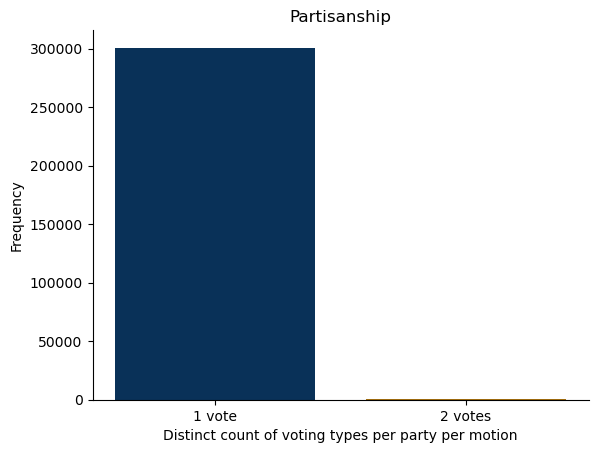

Unanimous: 99.65588164183208%
Divided: 0.3441183581679258%



 step 5: group parties
-----------------------------------------------------------------------



 step 6: evaluate partisanship
-----------------------------------------------------------------------


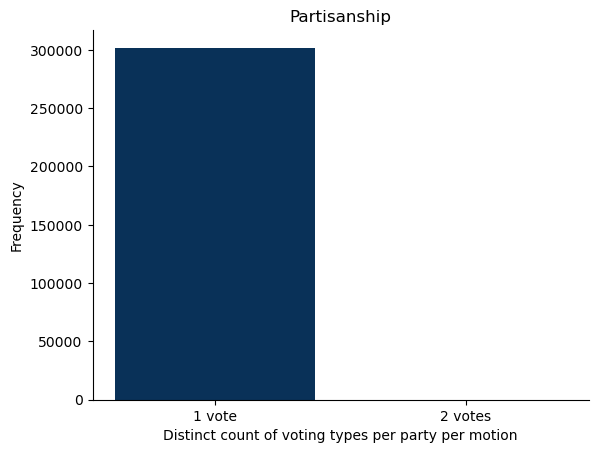

Unanimous: 100.0%
Divided: 0.0%



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
unique: True
length: 301854
day                                                            7
document_id                 08f70318-bcee-4284-95d8-25539822718c
party                                                     50PLUS
subject        Motie van de leden Van der Staaij en Roemer ov...
title               Nota over de toestand van ’s Rijks Financiën
stemming_id                 de29f06b-cab4-416b-82a1-cddc3a610551
besluit_id                  78dee20f-5f17-4697-9e40-201dc0c3f88f
vote                                                           1
Name: 0, dtype: object
             0
day          0
document_id  0
party        0
subject      0
title        0
stemming_id  0
besluit_id   0
vote         0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



 step 7: evaluate class imbalance
-----------------------------------------------------------------------


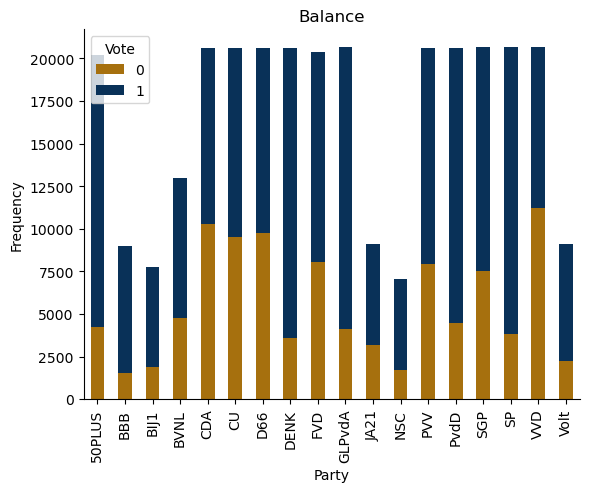




 step 8: display datasets
-----------------------------------------------------------------------

 retrieved dataset


,day,document_id,party,subject,title,stemming_id,besluit_id,vote
0,7,08f70318-bcee-4284-95d8-25539822718c,50PLUS,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,de29f06b-cab4-416b-82a1-cddc3a610551,78dee20f-5f17-4697-9e40-201dc0c3f88f,1
1,7,08f70318-bcee-4284-95d8-25539822718c,CDA,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,b317ab13-1ece-4434-8edd-bc361f18f640,78dee20f-5f17-4697-9e40-201dc0c3f88f,1
2,7,08f70318-bcee-4284-95d8-25539822718c,CU,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,91ffed0f-de9c-4d25-b448-61f47490a4a4,78dee20f-5f17-4697-9e40-201dc0c3f88f,1
3,7,08f70318-bcee-4284-95d8-25539822718c,D66,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,6f9227ef-0b27-406d-836d-fd9c5bf548b3,78dee20f-5f17-4697-9e40-201dc0c3f88f,1
4,7,08f70318-bcee-4284-95d8-25539822718c,DENK,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën,8b3b9edd-dc39-46db-9236-2b490eeb9188,78dee20f-5f17-4697-9e40-201dc0c3f88f,1


301854

 structured dataset


,stemming_id,document_id,party,day,vote
0,de29f06b-cab4-416b-82a1-cddc3a610551,08f70318-bcee-4284-95d8-25539822718c,50PLUS,7,1
1,b317ab13-1ece-4434-8edd-bc361f18f640,08f70318-bcee-4284-95d8-25539822718c,CDA,7,1
2,91ffed0f-de9c-4d25-b448-61f47490a4a4,08f70318-bcee-4284-95d8-25539822718c,CU,7,1
3,6f9227ef-0b27-406d-836d-fd9c5bf548b3,08f70318-bcee-4284-95d8-25539822718c,D66,7,1
4,8b3b9edd-dc39-46db-9236-2b490eeb9188,08f70318-bcee-4284-95d8-25539822718c,DENK,7,1


301854

 unstructured dataset


,document_id,subject,title
0,08f70318-bcee-4284-95d8-25539822718c,Motie van de leden Van der Staaij en Roemer ov...,Nota over de toestand van ’s Rijks Financiën
1,17e137d1-978d-4733-85c6-d0471ea12877,Motie van het lid Roemer c.s. . over nader ond...,Nota over de toestand van ’s Rijks Financiën
2,24c42b57-a9d0-4352-b495-9bc092cbcbc0,Motie van het lid Thieme over geen prioriteit ...,Nota over de toestand van ’s Rijks Financiën
3,360afadc-3439-4bd6-99a0-c8eb3619a15c,Motie van de leden Van der Staaij en Wilders o...,Nota over de toestand van ’s Rijks Financiën
4,3692e3b0-ad24-44d7-b225-5a31dbbd4233,Gewijzigde motie van het lid Asscher c.s. (t.v...,Nota over de toestand van ’s Rijks Financiën


20666

---------------------------------------------------------------------------------------------------------------------
Code duration: 20.238 seconds


In [52]:
dur = time.time()
file_url  = file_path + '11_data_structured_retrieved.csv'            
data = pd.read_csv(file_url)
# -------------------------------------------------------------------------------------~----------------------------------------

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['stemmingzaak_stemming_Id'].duplicated().any())}")          # print duplicates
print(f"length: {len(data)}")                                                          # print length
print(data.iloc[0])                                                                    # print row
print((data.isna().sum()).to_frame())                                                  # print nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# -------------------------------------------------------------------------------------~----------------------------------------
# step 1: redefine column names
print("\n step 1: redefine column names")                                          # print step
print("-----------------------------------------------------------------------")
column_names_redefined = {                                                             # define new column names
'stemmingzaak_stemming_Id':'stemming_id',
'stemmingzaak_stemming_Soort':'stemming_soort',
'stemmingzaak_stemming_Fractie.Id':'fractie_id',
'stemmingzaak_stemming_Fractie.Afkorting':'party',
'stemmingzaak_stemming_Besluit.Id':'besluit_id',
'stemmingzaak_zaak_Id':'zaak_id',
'stemmingzaak_zaak_GestartOp':'day',
'document_Id':'document_id',
'document_Titel':'title',
'document_Onderwerp':'subject'}
data.rename(columns=column_names_redefined, inplace=True)                              # rename columns
data = data.drop(columns=['fractie_id','zaak_id'])                                     # drop fractie_id and zaak_id

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['stemming_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
print(data.iloc[0])                                                                    # print row
print((data.isna().sum()).to_frame())                                                  # print nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# step 2: process day
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 2: process day")                                                    # print step
print("-----------------------------------------------------------------------")
print("- redefine day into datetime value")                                            # print substep
print("- filter on Cabinet Rutte III-IV")                                              # print substep
print("- redefine day into numeric value")                                             # print substep
data['day'] = pd.to_datetime(data['day'], utc=True)                                    # redefine day into datetime value
start = pd.Timestamp('2017-10-26', tz='CET')                                           # start of Rutte III
end = pd.Timestamp('2023-07-07', tz='CET')                                             # end of Rutte IV
data = data[(data['day'] >= start) & (data['day'] <= end)]                             # filter data
data['day'] = data['day'].apply(lambda date: (date - start).days)                      # redefine day into numeric value


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['stemming_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
print(data.iloc[0])                                                                    # print row
print((data.isna().sum()).to_frame())                                                  # print nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# step 3: process party
# -------------------------------------------------------------------------------------~----------------------------------------
print("\n\n\n step 3: process party")                                                  # print step
print("-----------------------------------------------------------------------")
print("- remove parties")                                                              # print substep
print("- rename parties")                                                              # print substep

remove = [  'Ephraim'           ,                                                      # irrelevant demerger
            'Groep Krol/vKA'    ,                                                      # discontinued party
            'Krol'              ,                                                      # discontinued party
            'Gündoğan'          ,                                                      # quit politics
            'vKA'               ]                                                      # quit politics

rename =  { 'Fractie Den Haan'  : '50PLUS' ,                                           # for analytical purposes, same name
            'Omtzigt'           : 'NSC'    ,                                           # relevant demerger into NSC
            'Groep Van Haga'    : 'BVNL'   ,                                           # relevant demerger into BVNL
            'Van Haga'          : 'BVNL'   ,                                           # relevant demerger into BVNL
            'GL'                : 'GLPvdA' ,                                           # relevant merger into GLPvdA
            'PvdA'              : 'GLPvdA'   }                                         # relevant merger into GLPvdA

data = data[~data['party'].isin(remove)]                                               # remove parties            
data['party'] = data['party'].replace(rename)                                          # rename parties


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['stemming_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
print(data.iloc[0])                                                                    # print row
print((data.isna().sum()).to_frame())                                                  # print nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





# -------------------------------------------------------------------------------------~----------------------------------------
# step 4: evaluate partisanship
print("\n\n\n step 4: evaluate partisanship")                                          # print step
print("-----------------------------------------------------------------------")
count = data.groupby(['party','besluit_id'])['stemming_soort'].nunique().reset_index() # define count
unanimous = len(count[count['stemming_soort'] == 1])                                   # define count unanimous
divided = len(count[count['stemming_soort'] == 2])                                     # define count divided

plt.bar(['1 vote', '2 votes'], [unanimous, divided] , color= ['#093158','#A6700E'])    # plot barplot
plt.xlabel('Distinct count of voting types per party per motion')                      # plot x label
plt.ylabel('Frequency')                                                                # plot y label
plt.title('Partisanship')                                                              # plot title
sns.despine()                                                                          # plot despine
plt.show()                                                                             # plot show
print(f"Unanimous: {((unanimous / (unanimous + divided)) * 100)}%")                    # print percentage unanimous
print(f"Divided: {((divided / (unanimous + divided)) * 100  )}%")                      # print percentage divided


# -------------------------------------------------------------------------------------~----------------------------------------
# Step 5: group parties
print("\n\n\n step 5: group parties")                                                  # print step
print("-----------------------------------------------------------------------")
data['voor'] = (data['stemming_soort'] == 'Voor').astype(int)                          # define voor column
data['tegen'] = (data['stemming_soort'] == 'Tegen').astype(int)                        # define tegen column
exclude = ['stemming_id','stemming_soort','besluit_id','voor','tegen']                 # define excluded columns
data = data.groupby(data.columns.difference(exclude).tolist()).agg({                   # aggregate, without excluded
            'voor'        : 'sum'   ,                                                  # sum yes votes
            'tegen'       : 'sum'   ,                                                  # sum no votes
            'stemming_id' : 'first' ,                                                  # first stemming_id
            'besluit_id'  : 'first' , }).reset_index()                                 # first besluit_id
data['vote']=data.apply(lambda row: 1 if row['voor'] >= row['tegen'] else 0, axis=1)   # define stemming result, majority
data = data.drop(columns=['voor','tegen'])                                             # drop voor and tegen


# -------------------------------------------------------------------------------------~----------------------------------------
# step 6: re-evaluate partisanship
print("\n\n\n step 6: evaluate partisanship")                                          # print step
print("-----------------------------------------------------------------------")
temp = data.groupby(['party','besluit_id'])['vote'].nunique().reset_index()            # define count
unanimous = len(temp[temp['vote'] == 1])                                               # define count unanimous
divided = len(temp[temp['vote'] == 2])                                                 # define count divided

plt.bar(['1 vote', '2 votes'], [unanimous, divided], color = '#093158')                # plot barplot
plt.xlabel('Distinct count of voting types per party per motion')                      # plot x label
plt.ylabel('Frequency')                                                                # plot y label
plt.title('Partisanship')                                                              # plot title
sns.despine()                                                                          # plot despine
plt.show()                                                                             # plot show
print(f"Unanimous: {((unanimous / (unanimous + divided)) * 100)}%")                    # print percentage unanimous
print(f"Divided: {((divided / (unanimous + divided)) * 100  )}%")                      # print percentage divided


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"unique: {(not data['stemming_id'].duplicated().any())}")                       # print duplicates
print(f"length: {len(data)}")                                                          # print length
print(data.iloc[0])                                                                    # print row
print((data.isna().sum()).to_frame())                                                  # print nulls
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~





# -------------------------------------------------------------------------------------~----------------------------------------
# step 7: evaluate class imbalance
print("\n\n\n step 7: evaluate class imbalance")                                       # print step
print("-----------------------------------------------------------------------")
temp = data.groupby(['party','vote'])['besluit_id'].count().unstack(fill_value=0)      # group data
col = {1: '#093158', 0: '#A6700E'}                                                     # define colors
temp.plot(kind='bar', stacked=True, color=[col.get(c, 'gray') for c in temp.columns])  # plot barplot
plt.xlabel('Party')                                                                    # plot x label
plt.ylabel('Frequency')                                                                # plot y label
plt.title('Balance')                                                                   # plot title
plt.legend(title='Vote')                                                               # plot legend
sns.despine()                                                                          # plot despine
plt.show()                                                                             # plot show


# -------------------------------------------------------------------------------------~----------------------------------------
# Step 8: display datasets
print("\n\n\n step 8: display datasets")                                                 
print("-----------------------------------------------------------------------")
structured_data = data[['stemming_id','document_id', 'party', 'day', 'vote']]          # define structured dataset
unstructured_data = data[['document_id', 'subject', 'title']]                          # define unstructured dataset
unstructured_data = unstructured_data.drop_duplicates(subset=[ 'document_id'])         # redefine into unique rows
structured_data.reset_index(drop=True, inplace=True)
unstructured_data.reset_index(drop=True, inplace=True)

print("\n retrieved dataset")                                                          # print retrieved dataset
display(data.head())                                                                   # display retrieved dataset
print(len(data))                                                                       # display retrieved dataset

print("\n structured dataset")                                                         # print structured dataset
display(structured_data.head())                                                        # display structured dataset
print(len(structured_data))                                                            # display structured dataset
file_url  = file_path + '12_data_structured_processed.csv'      
structured_data.to_csv(file_url, index=False)          

print("\n unstructured dataset")                                                       # print unstructured dataset
display(unstructured_data.head())                                                      # display unstructured dataset
print(len(unstructured_data))                                                          # display unstructured dataset
file_url  = file_path + '21_data_unstructured_base.csv'  
unstructured_data.to_csv(file_url, index=False)   

parties = [(party) for party in data['party'].unique()]                                # define list of parties
np.save('00_parties.npy', parties)                                                     # save list of parties

# -------------------------------------------------------------------------------------~----------------------------------------
print('\n---------------------------------------------------------------------------------------------------------------------')
print(f"Code duration: {round((time.time()  - dur),3)} seconds")       